In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings 
import pathlib 
import os 
import ot

warnings.filterwarnings("ignore")

project = "ecd_wgs_enriched_features"
inputdir = "/Volumes/HNSD01/storage/ecd_wgs_highdepth_full_features"
outputdir = f"/Volumes/HNSD01/outdir/{project}"

path_to_00_output = os.path.join(outputdir, "00_output")
os.system(f"mkdir -p {path_to_00_output}")

mainsrc = "/Users/hieunguyen/src/ecd_wgs_enriched_features"
metadata = pd.read_csv(os.path.join(mainsrc, "metadata.csv"))[["LABCODE", "Label"]]

all_input_samples = [item for item in pathlib.Path(inputdir).glob("*") if "DS_Store" not in item.name]

flendf = pd.DataFrame(data = range(50, 351), columns = ["size"])
for input_sample in all_input_samples:
    tmp_flendf = pd.read_csv([item for item in pathlib.Path(os.path.join(input_sample)).glob("*GWfeature_FLEN*")][0])[["size", "freq"]].copy()
    tmp_flendf.columns = ["size", input_sample.name.split("_")[0].split("-")[1]]
    flendf = flendf.merge(tmp_flendf, on="size", how="left")

emdf = pd.DataFrame(data = [f"{i}{j}{k}{l}" for i in ["A", "T", "G", "C"] for j in ["A", "T", "G", "C"] for k in ["A", "T", "G", "C"] for l in ["A", "T", "G", "C"]] , columns = ["motif"])
for input_sample in all_input_samples:
    tmp_emdf = pd.read_csv([item for item in pathlib.Path(os.path.join(input_sample)).glob("*GWfeature_EM*")][0])[["motif", "freq"]].copy()
    tmp_emdf.columns = ["motif", input_sample.name.split("_")[0].split("-")[1]]
    emdf = emdf.merge(tmp_emdf, on="motif", how="left")
    
nddf = pd.DataFrame(data = range(-300, 301), columns = ["dist"])
for input_sample in all_input_samples:
    tmp_nddf = pd.read_csv([item for item in pathlib.Path(os.path.join(input_sample)).glob("*GWfeature_ND*")][0])[["dist", "freq"]].copy()
    tmp_nddf.columns = ["dist", input_sample.name.split("_")[0].split("-")[1]]
    nddf = nddf.merge(tmp_nddf, on="dist", how="left")
    
# color definition
colors = {"Control": "lightgray", "Cancer": "red"}
sample_labels = dict()
for item in metadata.LABCODE.unique():
    sample_labels[item] = metadata[metadata["LABCODE"] == item].Label.unique()[0]

# Data analysis

## Basic visualization

### Fragment length distribution

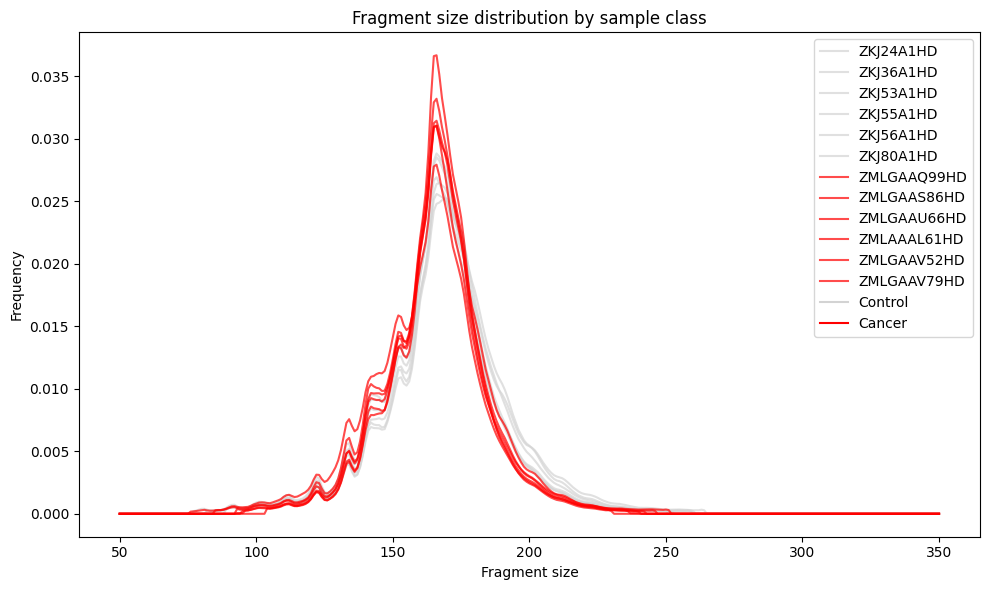

In [2]:
plt.figure(figsize=(10, 6))
for sample in metadata["LABCODE"]:
    plt.plot(flendf["size"], flendf[sample], label=sample, color=colors[sample_labels[sample]], alpha=0.7)

for label in colors:
    plt.plot([], [], color=colors[label], label=label)  # legend handles

plt.xlabel("Fragment size")
plt.ylabel("Frequency")
plt.title("Fragment size distribution by sample class")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(path_to_00_output, "fragment_size_distribution.pdf"))
plt.show()


### Distance to nearest nucleosomes

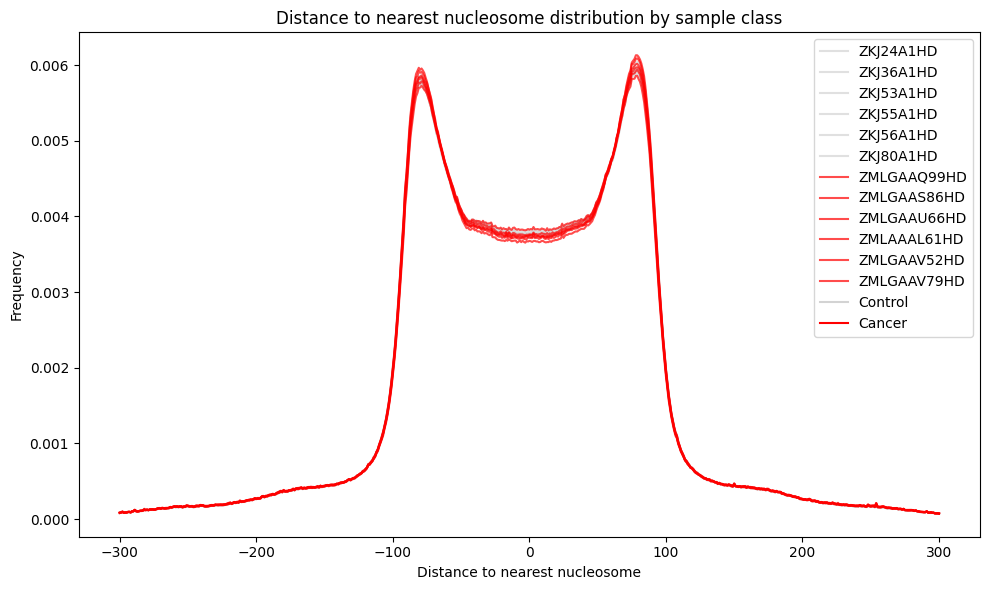

In [3]:
plt.figure(figsize=(10, 6))
for sample in metadata["LABCODE"]:
    plt.plot(nddf["dist"], nddf[sample], label=sample, color=colors[sample_labels[sample]], alpha=0.7)

for label in colors:
    plt.plot([], [], color=colors[label], label=label)  # legend handles

plt.xlabel("Distance to nearest nucleosome")
plt.ylabel("Frequency")
plt.title("Distance to nearest nucleosome distribution by sample class")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(path_to_00_output, "nucleosome_distance_distribution.pdf"))
plt.show()


## Statistics test to find differential features in end-motif

In [4]:
from scipy.stats import ttest_ind

# Get sample names for each class
control_samples = metadata[metadata["Label"] == "Control"]["LABCODE"].tolist()
cancer_samples = metadata[metadata["Label"] == "Cancer"]["LABCODE"].tolist()

# T-test for fragment length features
flen_ttest = []
for i, row in flendf.iterrows():
    control_vals = row[control_samples].values.astype(float)
    cancer_vals = row[cancer_samples].values.astype(float)
    stat, pval = ttest_ind(control_vals, cancer_vals, nan_policy='omit')
    flen_ttest.append({'size': row['size'], 't_stat': stat, 'p_value': pval})
flen_ttest_df = pd.DataFrame(flen_ttest)

# T-test for motif features
em_ttest = []
for i, row in emdf.iterrows():
    control_vals = row[control_samples].values.astype(float)
    cancer_vals = row[cancer_samples].values.astype(float)
    stat, pval = ttest_ind(control_vals, cancer_vals, nan_policy='omit')
    em_ttest.append({'motif': row['motif'], 't_stat': stat, 'p_value': pval})
em_ttest_df = pd.DataFrame(em_ttest)

# T-test for nucleosome distance features
nd_ttest = []
for i, row in nddf.iterrows():
    control_vals = row[control_samples].values.astype(float)
    cancer_vals = row[cancer_samples].values.astype(float)
    stat, pval = ttest_ind(control_vals, cancer_vals, nan_policy='omit')
    nd_ttest.append({'dist': row['dist'], 't_stat': stat, 'p_value': pval})
nd_ttest_df = pd.DataFrame(nd_ttest)

# Bonferroni correction for fragment length t-tests
flen_ttest_df["p_adj"] = np.minimum(flen_ttest_df["p_value"] * len(flen_ttest_df), 1.0)

# Bonferroni correction for motif t-tests
em_ttest_df["p_adj"] = np.minimum(em_ttest_df["p_value"] * len(em_ttest_df), 1.0)

# Bonferroni correction for nucleosome distance t-tests
nd_ttest_df["p_adj"] = np.minimum(nd_ttest_df["p_value"] * len(nd_ttest_df), 1.0)

os.system(f"mkdir -p { os.path.join(path_to_00_output, 't-test-results') }")

flen_ttest_df.to_excel(os.path.join(path_to_00_output, "t-test-results", "FLEN.xlsx"), index=False)
em_ttest_df.to_excel(os.path.join(path_to_00_output, "t-test-results", "EM.xlsx"), index=False)
nd_ttest_df.to_excel(os.path.join(path_to_00_output, "t-test-results", "ND.xlsx"), index=False)

In [5]:
os.system(f"mkdir -p {os.path.join(path_to_00_output, 'diff_end_motifs') }")
plt.figure(figsize=(6, 4))

for motif in em_ttest_df[em_ttest_df["p_adj"] <= 0.05].motif.unique():
    if os.path.isfile(os.path.join(path_to_00_output, "diff_end_motifs", f"motif_{motif}_frequency.pdf")) == False:
        motif_vals = emdf.loc[emdf["motif"] == motif, metadata["LABCODE"]].T
        motif_vals.columns = [motif]
        motif_vals["Label"] = metadata.set_index("LABCODE").loc[motif_vals.index, "Label"]

        sns.boxplot(x="Label", y=motif, data=motif_vals, palette={"Control": "lightgray", "Cancer": "red"})
        sns.stripplot(x="Label", y=motif, data=motif_vals, color="black", alpha=0.5, jitter=True)
        plt.title(f"Motif frequency: {motif}")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.savefig(os.path.join(path_to_00_output, "diff_end_motifs", f"motif_{motif}_frequency.pdf"))
        plt.show()

<Figure size 600x400 with 0 Axes>

## PCA 

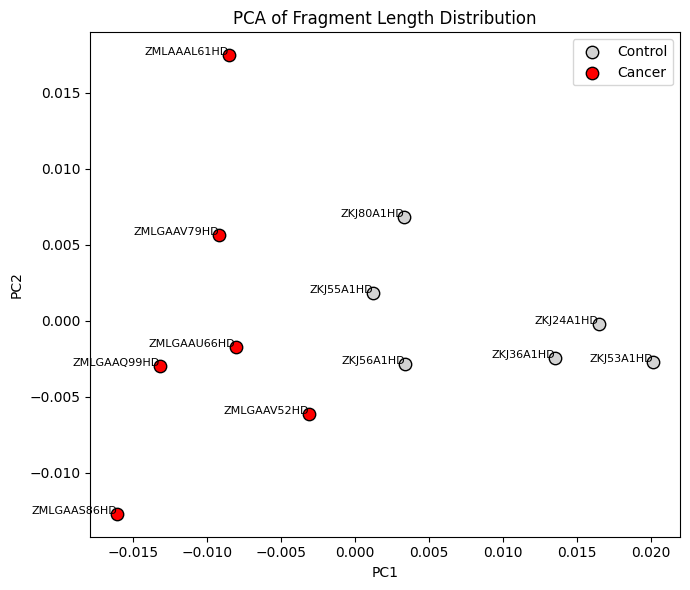

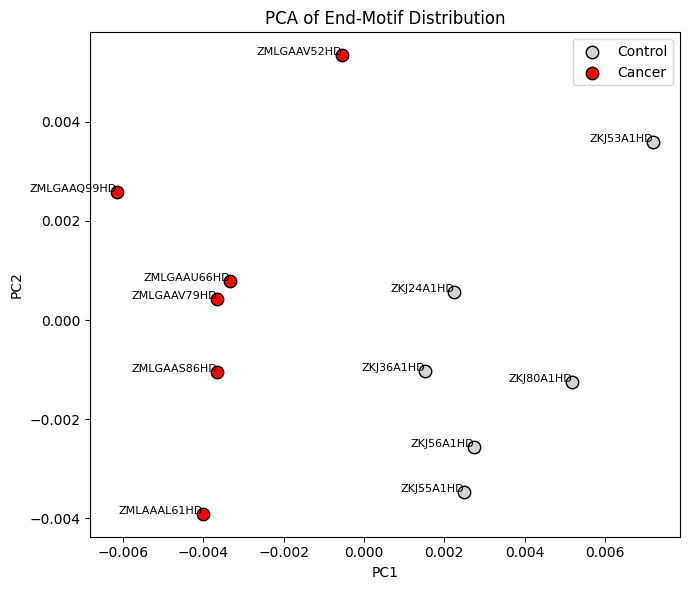

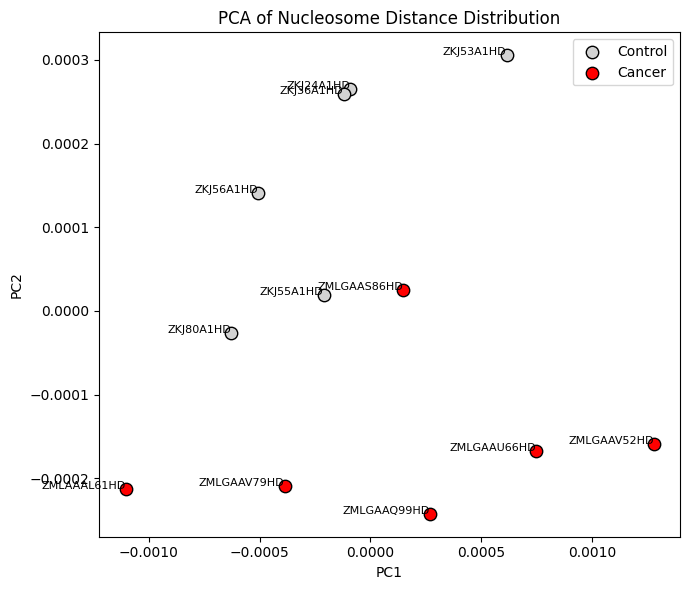

In [6]:
from sklearn.decomposition import PCA

def plot_pca(df, feature_col, sample_list, sample_labels, title, savename):
    os.system(f"mkdir -p {os.path.join(path_to_00_output, 'PCA')}")
    X = df[sample_list].T.values
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    labels = [sample_labels[s] for s in sample_list]

    plt.figure(figsize=(7, 6))
    for label in colors:
        idx = [i for i, l in enumerate(labels) if l == label]
        plt.scatter(X_pca[idx, 0], X_pca[idx, 1], c=colors[label], label=label, s=80, edgecolor='k')
    for i, sample in enumerate(sample_list):
        plt.text(X_pca[i, 0], X_pca[i, 1], sample, fontsize=8, ha='right')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(path_to_00_output, "PCA", f"{savename}.pdf"))
    plt.show()
    return X_pca

sample_list = metadata["LABCODE"].tolist()

_ = plot_pca(flendf, "size", sample_list, sample_labels, "PCA of Fragment Length Distribution", "FLEN")
_ = plot_pca(emdf, "motif", sample_list, sample_labels, "PCA of End-Motif Distribution", "EM")
_ = plot_pca(nddf, "dist", sample_list, sample_labels, "PCA of Nucleosome Distance Distribution", "ND")

## Optimal transport distance between samples 

In [7]:
def calculate_ot_distance(sample1, sample2, inputdf, n):
    x = np.arange(n, dtype=np.float64)
    M = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)), 'euclidean')
    M /= M.max() * 0.1
    a = inputdf[sample1].values
    a = np.array(a)
    b = inputdf[sample2].values
    d_emd = ot.emd2(a, b, M)  # direct computation of OT loss
    return d_emd

flen_distdf = pd.DataFrame(data =  metadata.LABCODE.unique(), columns = ["SampleID"])
for sampleid in flen_distdf.SampleID.unique():
    flen_distdf[sampleid] = flen_distdf["SampleID"].apply(lambda x: 
        calculate_ot_distance(sample1 = sampleid,
                            sample2 = x,
                            inputdf = flendf, 
                            n = flendf.shape[0]))
    
em_distdf = pd.DataFrame(data =  metadata.LABCODE.unique(), columns = ["SampleID"])
for sampleid in em_distdf.SampleID.unique():
    em_distdf[sampleid] = em_distdf["SampleID"].apply(lambda x: 
        calculate_ot_distance(sample1 = sampleid,
                            sample2 = x,
                            inputdf = emdf, 
                            n = emdf.shape[0]))
    
nd_distdf = pd.DataFrame(data =  metadata.LABCODE.unique(), columns = ["SampleID"])
for sampleid in nd_distdf.SampleID.unique():
    nd_distdf[sampleid] = nd_distdf["SampleID"].apply(lambda x: 
        calculate_ot_distance(sample1 = sampleid,
                            sample2 = x,
                            inputdf = nddf, 
                            n = nddf.shape[0]))

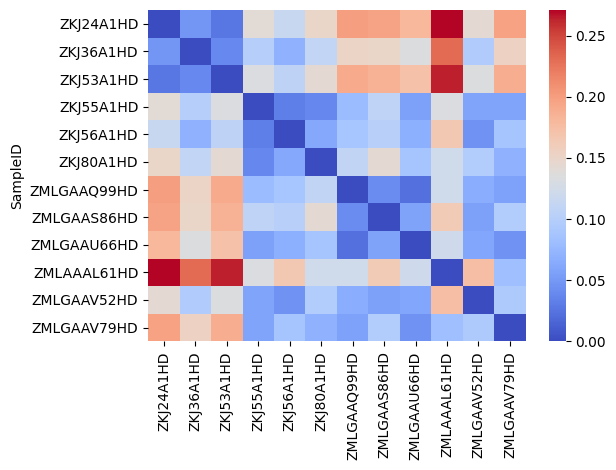

In [8]:
ordered_samples = control_samples + cancer_samples
os.system(f"mkdir -p {os.path.join(path_to_00_output, 'heatmap_OT_dist') }")
sns.heatmap(flen_distdf.set_index("SampleID").loc[ordered_samples][ordered_samples], cmap="coolwarm", annot=False, fmt=".2f")
plt.tight_layout()
plt.savefig(os.path.join(path_to_00_output, "heatmap_OT_dist", f"heatmap_flen_OT_dist.pdf"))
    

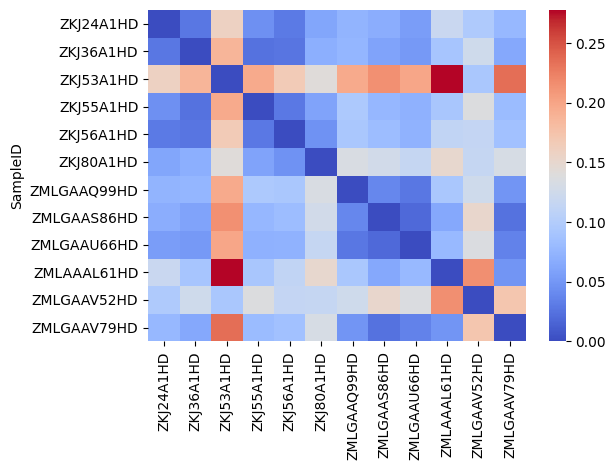

In [9]:
sns.heatmap(em_distdf.set_index("SampleID").loc[ordered_samples][ordered_samples], cmap="coolwarm", annot=False, fmt=".2f")
plt.tight_layout()
plt.savefig(os.path.join(path_to_00_output, "heatmap_OT_dist", f"heatmap_em_OT_dist.pdf"))


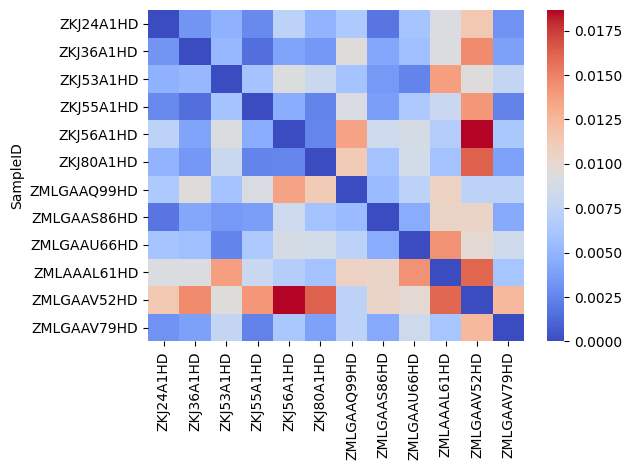

In [10]:
sns.heatmap(nd_distdf.set_index("SampleID").loc[ordered_samples][ordered_samples], cmap="coolwarm", annot=False, fmt=".2f")
plt.tight_layout()
plt.savefig(os.path.join(path_to_00_output, "heatmap_OT_dist", f"heatmap_nd_OT_dist.pdf"))


## MDS from optimal transport distance

### MDS for FLEN

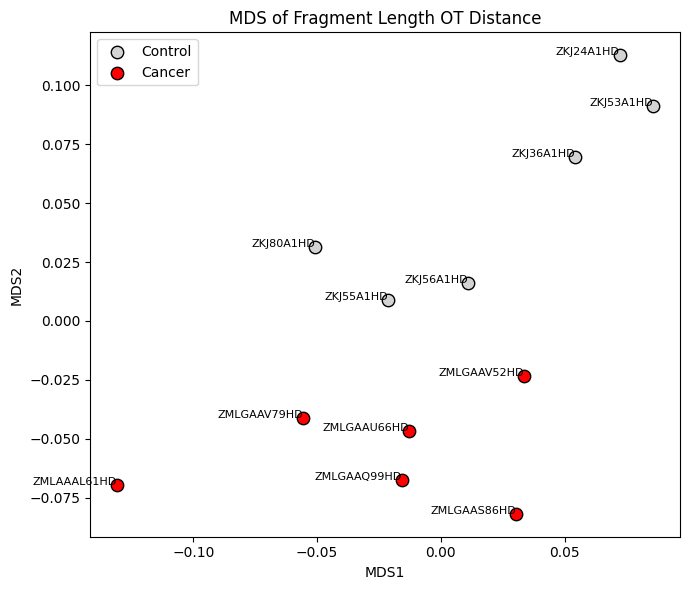

In [11]:
from sklearn.manifold import MDS

os.system(f"mkdir -p {os.path.join(path_to_00_output, 'MDS') } ")
# Prepare distance matrix for MDS
dist_matrix = flen_distdf[sample_list].values
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_coords = mds.fit_transform(dist_matrix)

# Plot MDS
plt.figure(figsize=(7, 6))
for label in colors:
    idx = [i for i, s in enumerate(sample_list) if sample_labels[s] == label]
    plt.scatter(mds_coords[idx, 0], mds_coords[idx, 1], c=colors[label], label=label, s=80, edgecolor='k')
for i, sample in enumerate(sample_list):
    plt.text(mds_coords[i, 0], mds_coords[i, 1], sample, fontsize=8, ha='right')
plt.xlabel("MDS1")
plt.ylabel("MDS2")
plt.title("MDS of Fragment Length OT Distance")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(path_to_00_output, "MDS", f"MDS_from_flen_dist.pdf"))

plt.show()

### MDS for EM

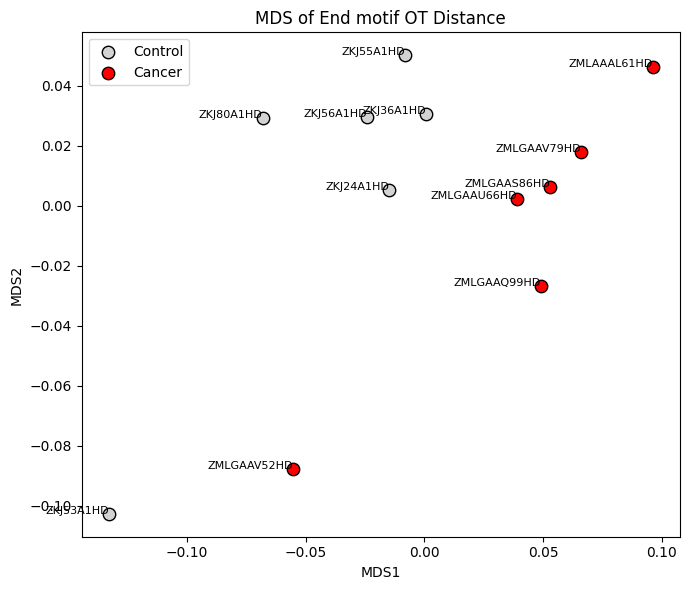

In [12]:
from sklearn.manifold import MDS

# Prepare distance matrix for MDS
dist_matrix = em_distdf[sample_list].values
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_coords = mds.fit_transform(dist_matrix)

# Plot MDS
plt.figure(figsize=(7, 6))
for label in colors:
    idx = [i for i, s in enumerate(sample_list) if sample_labels[s] == label]
    plt.scatter(mds_coords[idx, 0], mds_coords[idx, 1], c=colors[label], label=label, s=80, edgecolor='k')
for i, sample in enumerate(sample_list):
    plt.text(mds_coords[i, 0], mds_coords[i, 1], sample, fontsize=8, ha='right')
plt.xlabel("MDS1")
plt.ylabel("MDS2")
plt.title("MDS of End motif OT Distance")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(path_to_00_output, "MDS", f"MDS_from_em_dist.pdf"))
plt.show()

### MDS for ND

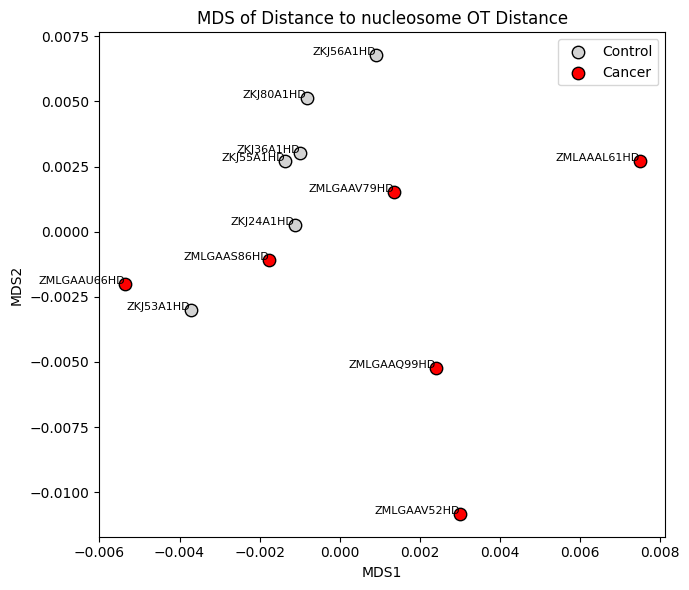

In [13]:
from sklearn.manifold import MDS

# Prepare distance matrix for MDS
dist_matrix = nd_distdf[sample_list].values
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_coords = mds.fit_transform(dist_matrix)

# Plot MDS
plt.figure(figsize=(7, 6))
for label in colors:
    idx = [i for i, s in enumerate(sample_list) if sample_labels[s] == label]
    plt.scatter(mds_coords[idx, 0], mds_coords[idx, 1], c=colors[label], label=label, s=80, edgecolor='k')
for i, sample in enumerate(sample_list):
    plt.text(mds_coords[i, 0], mds_coords[i, 1], sample, fontsize=8, ha='right')
plt.xlabel("MDS1")
plt.ylabel("MDS2")
plt.title("MDS of Distance to nucleosome OT Distance")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(path_to_00_output, "MDS", f"MDS_from_nd_dist.pdf"))

plt.show()

In [14]:
# Calculate average OT distance between Cancer and Control samples
control_samples = metadata[metadata["Label"] == "Control"]["LABCODE"].tolist()
cancer_samples = metadata[metadata["Label"] == "Cancer"]["LABCODE"].tolist()

def avg_group_distance(distdf, group1, group2):
    # Only consider off-diagonal pairs (not within same sample)
    distances = []
    for s1 in group1:
        for s2 in group2:
            if s1 != s2:
                distances.append(distdf.loc[distdf["SampleID"] == s1, s2].values[0])
    return np.mean(distances)

avg_flen_dist = avg_group_distance(flen_distdf, control_samples, cancer_samples)
avg_em_dist = avg_group_distance(em_distdf, control_samples, cancer_samples)
avg_nd_dist = avg_group_distance(nd_distdf, control_samples, cancer_samples)

print("Average OT distance (Fragment Length):", avg_flen_dist)
print("Average OT distance (End-Motif):", avg_em_dist)
print("Average OT distance (Nucleosome Distance):", avg_nd_dist)

avgdist = pd.DataFrame(data = [avg_flen_dist, avg_em_dist, avg_nd_dist], columns = ["avg_dist_full"])
avgdist["feature"] = ["flen", "em", "nd"]
avgdist.to_excel(os.path.join(path_to_00_output, "avg_OT_dist.xlsx"), index = False)

Average OT distance (Fragment Length): 0.13656044431782677
Average OT distance (End-Motif): 0.11254885027390987
Average OT distance (Nucleosome Distance): 0.007924814373159677


In [15]:
def calculate_barycenter(inputdf, samplelist, n, show_plot=False, M = None):
    first_sample = samplelist[0]

    A = inputdf[[first_sample]].to_numpy()
    for sampleid in samplelist[1:]:
        a2 = inputdf[[sampleid]].to_numpy()
        A = np.hstack((A, a2))
    n_distributions = A.shape[1]

    # loss matrix + normalization
    if M is None:
        M = ot.utils.dist0(n)
        M /= M.max()

    weights = [1/n_distributions for item in range(n_distributions)]
    x = np.arange(n, dtype=np.float64)
    # l2bary
    bary_l2 = A.dot(weights)

    if show_plot:
        f, (ax1, ax2) = plt.subplots(2, 1, tight_layout=True, num=1)
        ax1.plot(x, A, color="black")
        ax1.set_title('Distributions')

        ax2.plot(x, bary_l2, 'r', label='l2')
        ax2.set_title('Barycenters')

        plt.legend()
        plt.show()
    return bary_l2

def calculate_ot_distance_of_barycenter(inputdf, group1, group2):
    a = calculate_barycenter(inputdf, group1, inputdf.shape[0])
    b = calculate_barycenter(inputdf, group2, inputdf.shape[0])
    n = inputdf.shape[0]
    x = np.arange(n, dtype=np.float64)
    M = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)), 'euclidean')
    M /= M.max() * 0.1
    a = np.array(a)
    d_emd = ot.emd2(a, b, M)  # direct computation of OT loss
    return(d_emd)

flen_barycenter_dist = calculate_ot_distance_of_barycenter(flendf, control_samples, cancer_samples)
em_barycenter_dist = calculate_ot_distance_of_barycenter(emdf, control_samples, cancer_samples)
nd_barycenter_dist = calculate_ot_distance_of_barycenter(nddf, control_samples, cancer_samples)

print("Average OT distance (Fragment Length):", flen_barycenter_dist)
print("Average OT distance (End-Motif):", em_barycenter_dist)
print("Average OT distance (Nucleosome Distance):", nd_barycenter_dist)

avgdist = pd.DataFrame(data = [flen_barycenter_dist, em_barycenter_dist, nd_barycenter_dist], columns = ["avg_dist_full"])
avgdist["feature"] = ["flen", "em", "nd"]
avgdist.to_excel(os.path.join(path_to_00_output, "avg_barycenter_OT_dist.xlsx"), index = False)

Average OT distance (Fragment Length): 0.11721271709892224
Average OT distance (End-Motif): 0.08570089463516294
Average OT distance (Nucleosome Distance): 0.005166694883635879


## Diversity metrics

### Fragment length entropy

<Axes: xlabel='Label', ylabel='entropy'>

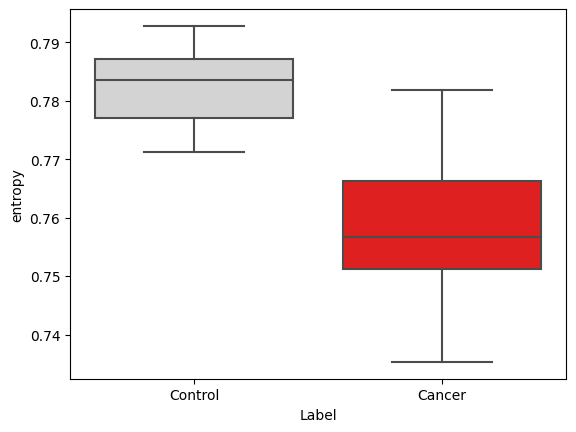

In [16]:
entropydf = pd.DataFrame(data = metadata.LABCODE.unique(), columns = ["LABCODE"])
entropydf["entropy"] = entropydf["LABCODE"].apply(lambda x: 
    -np.sum([i * np.log2(i) for i in flendf[x] if i > 0])/np.log2(flendf.shape[0])
)
entropydf = entropydf.merge(metadata, right_on = "LABCODE", left_on = "LABCODE")
entropydf.to_excel(os.path.join(path_to_00_output, "fragment_length_entropy.xlsx"), index = False)
sns.boxplot(data = entropydf, x = "Label", y = "entropy", palette={"Control": "lightgray", "Cancer": "red"})


### End motif entropy

<Axes: xlabel='Label', ylabel='entropy'>

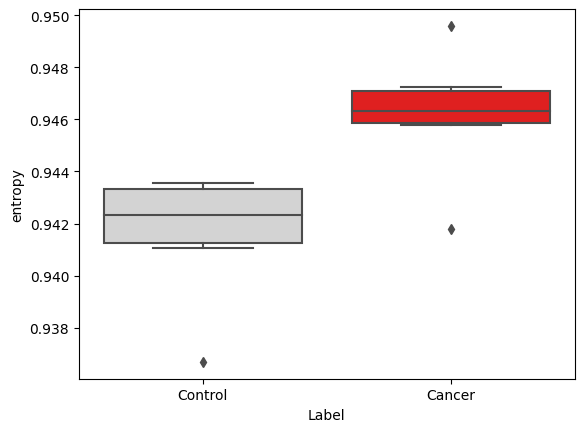

In [17]:
entropydf = pd.DataFrame(data = metadata.LABCODE.unique(), columns = ["LABCODE"])
entropydf["entropy"] = entropydf["LABCODE"].apply(lambda x: 
    -np.sum([i * np.log2(i) for i in emdf[x] if i > 0])/np.log2(emdf.shape[0])
)
entropydf = entropydf.merge(metadata, right_on = "LABCODE", left_on = "LABCODE")
entropydf.to_excel(os.path.join(path_to_00_output, "end_motif_entropy.xlsx"), index = False)
sns.boxplot(data = entropydf, x = "Label", y = "entropy", palette={"Control": "lightgray", "Cancer": "red"})


## Unsupervised clustering and ARI

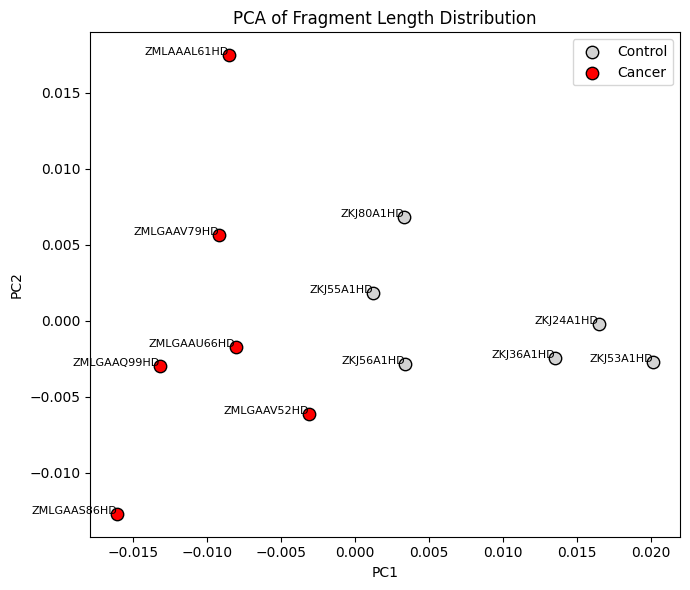

ARI (Fragment Length, kNN clustering): 0.3956043956043956
ARI ranges from -1 to 1. A score close to 1 means the clustering matches the true labels well, 0 means random labeling, and negative values indicate worse than random.


In [18]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import adjusted_rand_score

def knn_cluster(X, k):
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
    _, indices = nbrs.kneighbors(X)
    # Exclude self (first index)
    labels = []
    for idx in indices:
        neighbors = idx[1:]  # skip self
        # Assign label by majority vote among neighbors
        neighbor_labels = [true_labels[i] for i in neighbors]
        labels.append(max(set(neighbor_labels), key=neighbor_labels.count))
    return labels

# Use PCA-reduced data for clustering
X_pca = plot_pca(flendf, "size", sample_list, sample_labels, "PCA of Fragment Length Distribution", "FLEN")

true_labels = [sample_labels[s] for s in sample_list]

# kNN clustering (k=3)
pred_labels = knn_cluster(X_pca, k=4)

# ARI score
ari_score = adjusted_rand_score(true_labels, pred_labels)
print("ARI (Fragment Length, kNN clustering):", ari_score)
print("ARI ranges from -1 to 1. A score close to 1 means the clustering matches the true labels well, 0 means random labeling, and negative values indicate worse than random.")


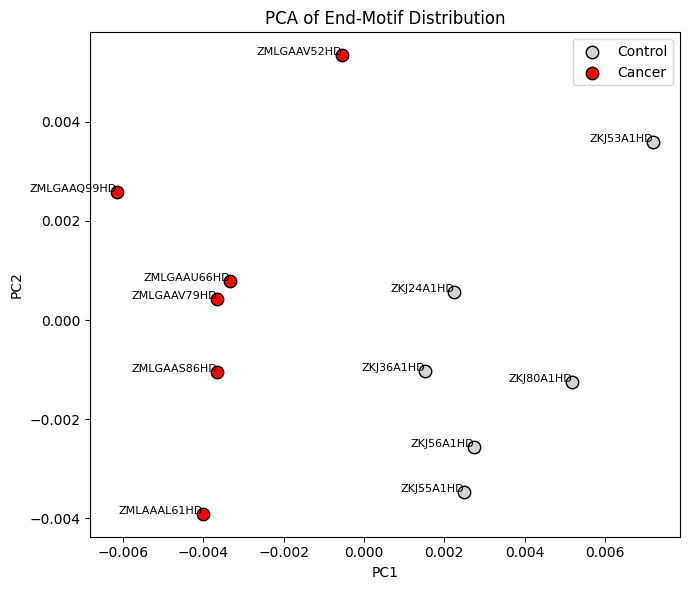

ARI (Fragment Length, kNN clustering): 1.0


In [19]:
# Use PCA-reduced data for clustering
X_pca = plot_pca(emdf, "motif", sample_list, sample_labels, "PCA of End-Motif Distribution", "EM")
true_labels = [sample_labels[s] for s in sample_list]

# kNN clustering (k=3)
pred_labels = knn_cluster(X_pca, k=3)

# ARI score
ari_score = adjusted_rand_score(true_labels, pred_labels)
print("ARI (Fragment Length, kNN clustering):", ari_score)


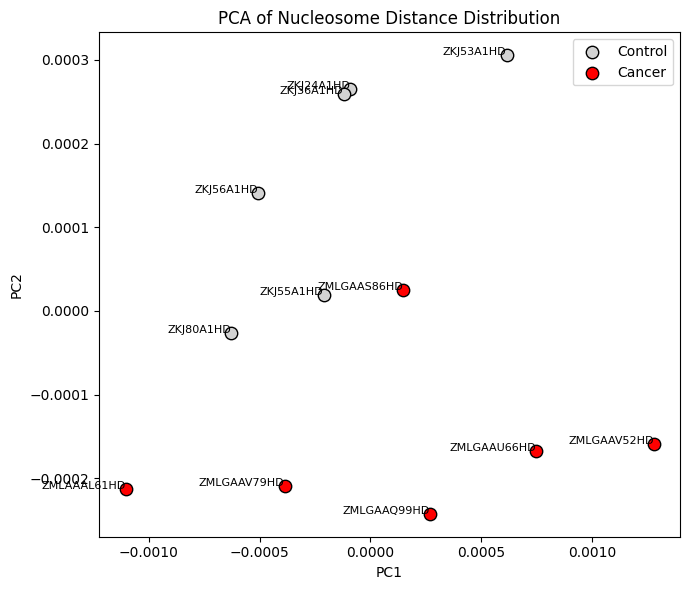

ARI (Fragment Length, kNN clustering): 0.03296703296703297


In [20]:
# Use PCA-reduced data for clustering
X_pca = plot_pca(nddf, "dist", sample_list, sample_labels, "PCA of Nucleosome Distance Distribution", "ND")
true_labels = [sample_labels[s] for s in sample_list]

# kNN clustering (k=3)
pred_labels = knn_cluster(X_pca, k=3)

# ARI score
ari_score = adjusted_rand_score(true_labels, pred_labels)
print("ARI (Fragment Length, kNN clustering):", ari_score)
